In [1]:
import requests
import zipfile 
import matplotlib.pyplot as plt
import cv2
import os
import glob

## Install Segment Anything

In [2]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-w7eps3be
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-w7eps3be
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5c01eae21a54e8b9c2645b33bf463a2a385e00dfc8ca93b84e9df84079741a4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-7hui9ipb/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


## Download the Data

In [3]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
        
download_file(
    'https://www.dropbox.com/s/0etn81u50kfs2ah/input.zip?dl=1',
    'input.zip'
)

In [ ]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('input.zip')

Extracted all


## Download the Models 

In [5]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h.pth

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -O sam_vit_l.pth

--2025-11-30 14:07:22--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.123, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h.pth’

sam_vit_h.pth       100%[===================>]   2.39G  30.2MB/s    in 18s     

2025-11-30 14:07:40 (136 MB/s) - ‘sam_vit_h.pth’ saved [2564550879/2564550879]

--2025-11-30 14:07:40--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.123, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.

## Inference

In [ ]:
%%writefile segment.py
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import torch

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

parser = argparse.ArgumentParser()
parser.add_argument(
    '--input',
    default='input/image_4.jpg'
)
args = parser.parse_args()

if not os.path.exists('outputs'):
    os.makedirs('outputs')

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        np.dstack((img, m*0.35))
        ax.imshow(np.dstack((img, m*0.35)))

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h.pth")
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

image_path = args.input
image_name = image_path.split(os.path.sep)[-1]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
plt.figure(figsize=(12, 9))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.savefig(os.path.join('outputs', image_name), bbox_inches='tight')

Writing segment.py


In [7]:
!python segment.py --input input/image_1.jpg 
!python segment.py --input input/image_2.jpg
!python segment.py --input input/image_3.jpg
!python segment.py --input input/image_4.jpg 

## Visualize Results

In [8]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

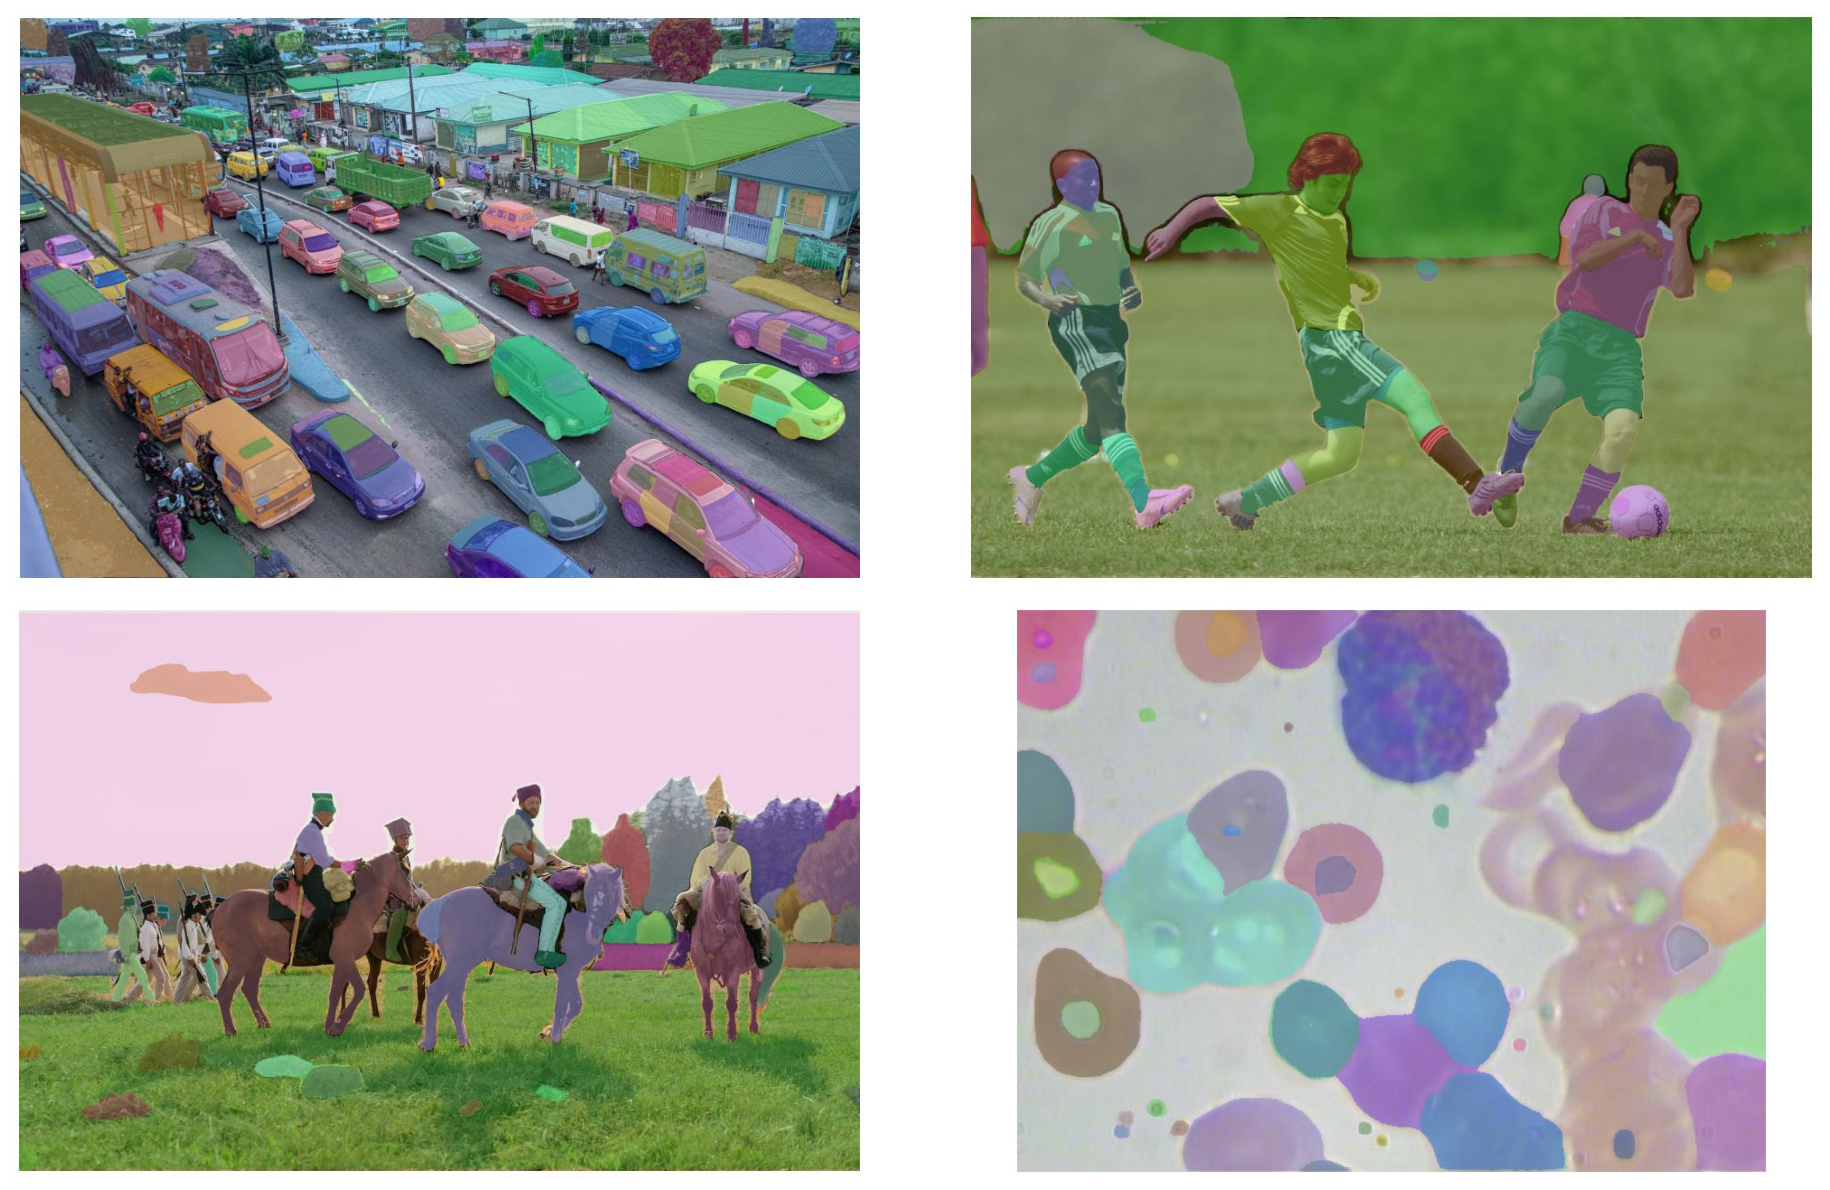

In [9]:
visualize('outputs')